

# CART POLE



In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1,929 kB]


In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(4, 4, 4, 4), (5, 5, 5, 5)]


In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.06397368  0.0372522 ]


In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.06397368  0.0372522 ]


Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

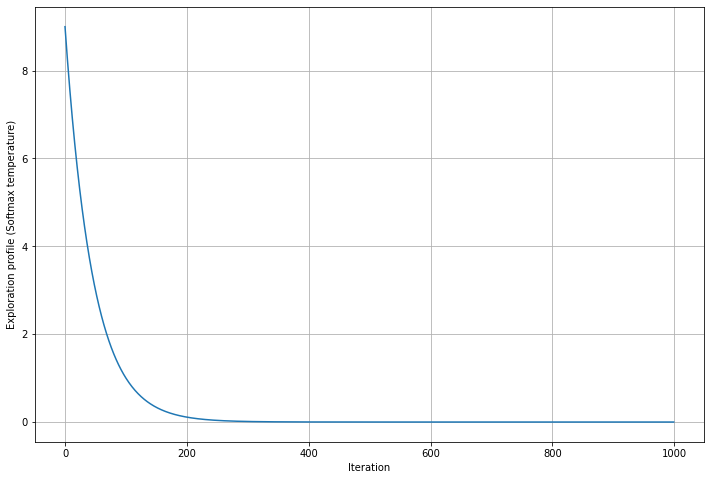

In [ ]:
### Define exploration profile
initial_value = 9
mul_iter = 10
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * mul_iter) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 11.0
EPISODE 2 - FINAL SCORE: 21.0
EPISODE 3 - FINAL SCORE: 25.0
EPISODE 4 - FINAL SCORE: 17.0
EPISODE 5 - FINAL SCORE: 12.0
EPISODE 6 - FINAL SCORE: 23.0
EPISODE 7 - FINAL SCORE: 14.0
EPISODE 8 - FINAL SCORE: 13.0
EPISODE 9 - FINAL SCORE: 10.0
EPISODE 10 - FINAL SCORE: 19.0


In [ ]:
# Display the videos, not required outside Colab
#show_videos()

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
scores = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      pos_weight = -1
      reward = reward + pos_weight * np.abs(state[0])

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    scores.append(score)
env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 9.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 8.80440647156254
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 8.613063701832482
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 8.42587931071048
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 8.242762925758251
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 8.06362613856686
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 7.8883824620732135
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 7.716947288804205
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 7.549237850028304
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 7.385173175794898
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 7.224674055842075
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 7.067663001353995
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 6.91406420754936
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 6.7638035170829465
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 6.616808384242507
EPISODE: 16 - FINAL SCORE:

No handles with labels found to put in legend.


Text(0, 0.5, 'Scores')

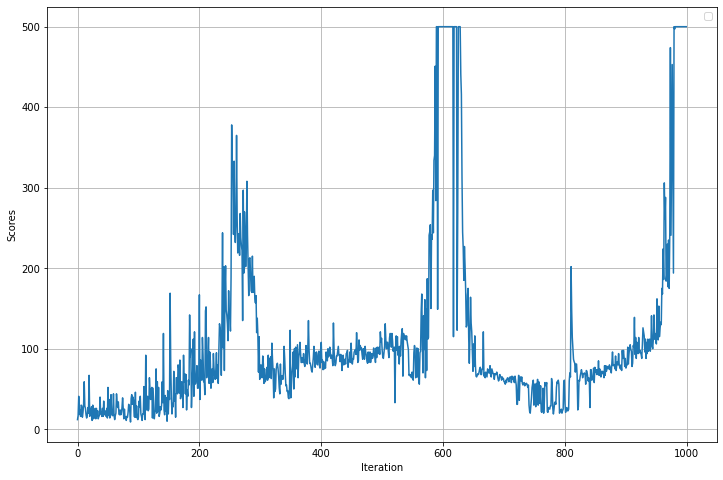

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(scores)
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.2.61.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.61.video000009.mp4


# MOUNTAIN CAR

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:15 http://ppa.lau

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(5, 5, 5, 5), (3, 3, 3, 3)]


In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim, hidden_neurons = 128):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, hidden_neurons),
                nn.Tanh(),
                nn.Linear(hidden_neurons, hidden_neurons),
                nn.Tanh(),
                nn.Linear(hidden_neurons, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [ ]:


# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      #env.render()
      # Update the final score (+1 for each step)
      score += reward
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: -200.0
EPISODE 2 - FINAL SCORE: -200.0
EPISODE 3 - FINAL SCORE: -200.0
EPISODE 4 - FINAL SCORE: -200.0
EPISODE 5 - FINAL SCORE: -200.0
EPISODE 6 - FINAL SCORE: -200.0
EPISODE 7 - FINAL SCORE: -200.0
EPISODE 8 - FINAL SCORE: -200.0
EPISODE 9 - FINAL SCORE: -200.0
EPISODE 10 - FINAL SCORE: -200.0


In [ ]:
#show_videos()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

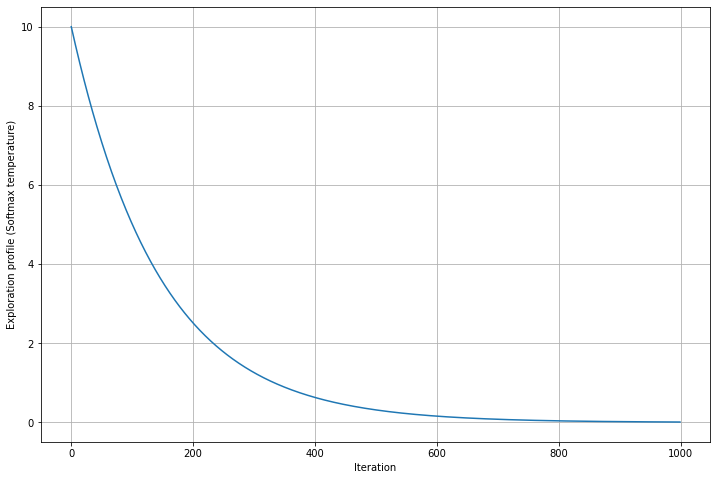

In [ ]:
### Define exploration profile
initial_value = 10
mul_iter = 3
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * mul_iter) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
scores = []
max_pos = -1.3
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    epsilon = tau / 10

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon)#choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      position = state[0]
      velocity = state[1]

      pos_weight = 6

      #reward function. Give more reward if a good position is reached, give a penalty if the position reached is not better than maximal position
      reward = position + 0.5

      if position >= 0.2:
        reward += 1
      if position < max_pos:
        reward -= 2
      if position >= max_pos:
        max_pos = position

      # Update the final score. The score is the position of the car in the environment
      score = position

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - Reward: {reward} MaxPosition: {max_pos}") # Print the final score
    scores.append(score)
env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: -0.6092621234924952 - Temperature: 10.0 - Reward: -2.109262123492495 MaxPosition: -0.5219908098368623
EPISODE: 2 - FINAL SCORE: -0.6751102438531645 - Temperature: 9.931160484209338 - Reward: -2.1751102438531644 MaxPosition: -0.4069218125515359
EPISODE: 3 - FINAL SCORE: -0.6761608054121795 - Temperature: 9.862794856312107 - Reward: -2.1761608054121795 MaxPosition: -0.4069218125515359
EPISODE: 4 - FINAL SCORE: -0.5344318883481485 - Temperature: 9.79489985408699 - Reward: -2.0344318883481485 MaxPosition: -0.4069218125515359
EPISODE: 5 - FINAL SCORE: -0.6532208710788211 - Temperature: 9.727472237769653 - Reward: -2.153220871078821 MaxPosition: -0.4069218125515359
EPISODE: 6 - FINAL SCORE: -0.6514778326713973 - Temperature: 9.660508789898136 - Reward: -2.1514778326713975 MaxPosition: -0.4069218125515359
EPISODE: 7 - FINAL SCORE: -0.6329091085648968 - Temperature: 9.594006315159334 - Reward: -2.132909108564897 MaxPosition: -0.4069218125515

No handles with labels found to put in legend.


Text(0, 0.5, 'Scores')

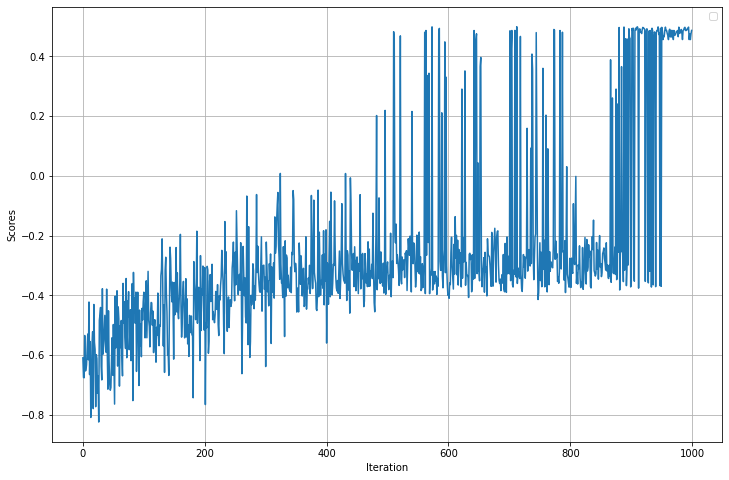

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(scores)
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, state, 0)#choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score = state[0] 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 0.48584261662994443
EPISODE 2 - FINAL SCORE: 0.47996573012175126
EPISODE 3 - FINAL SCORE: 0.45647026925855894
EPISODE 4 - FINAL SCORE: 0.45647026925855894
EPISODE 5 - FINAL SCORE: 0.4887899843094383
EPISODE 6 - FINAL SCORE: 0.45647026925855894
EPISODE 7 - FINAL SCORE: 0.45647026925855894
EPISODE 8 - FINAL SCORE: 0.48002812463576283
EPISODE 9 - FINAL SCORE: 0.4627507459580106
EPISODE 10 - FINAL SCORE: 0.4660639330842401


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.3.7761.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.7761.video000009.mp4


# PIXEL BASED CART POLE

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 163 kB in 2s (83.4 kB/s)
Reading

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(5, 5, 5, 5), (3, 3, 3, 3)]


In [ ]:
def get_frame(env):
  image = env.render(mode='rgb_array').copy()
  #image = np.flip(image, axis=0)
  to_tensor = torchvision.transforms.ToTensor()
  image = to_tensor(image)
  pooling = nn.AvgPool2d(8)
  image = pooling(image)
  image = image.unsqueeze(0)
  return image[:, 0:1, :, :]

In [ ]:
def stack_frames(frames):
  #tensor = torch.tensor(frames)
  return torch.cat(frames, dim=0)

torch.Size([1, 1, 50, 75])
EPISODE 1 - FINAL SCORE: 39.0
torch.Size([1, 1, 50, 75])
EPISODE 2 - FINAL SCORE: 29.0
torch.Size([1, 1, 50, 75])
EPISODE 3 - FINAL SCORE: 45.0
torch.Size([1, 1, 50, 75])
EPISODE 4 - FINAL SCORE: 10.0
torch.Size([1, 1, 50, 75])
EPISODE 5 - FINAL SCORE: 11.0
torch.Size([1, 1, 50, 75])
EPISODE 6 - FINAL SCORE: 11.0
torch.Size([1, 1, 50, 75])
EPISODE 7 - FINAL SCORE: 19.0
torch.Size([1, 1, 50, 75])
EPISODE 8 - FINAL SCORE: 18.0
torch.Size([1, 1, 50, 75])
EPISODE 9 - FINAL SCORE: 38.0
torch.Size([1, 1, 50, 75])
EPISODE 10 - FINAL SCORE: 21.0


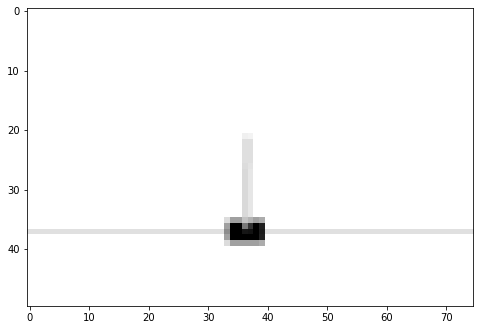

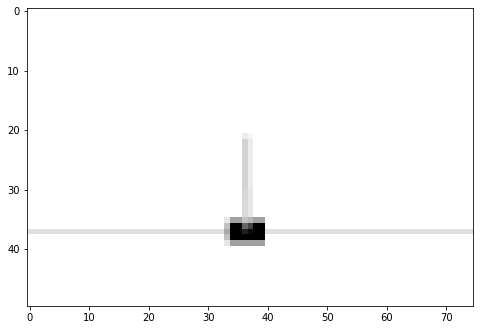

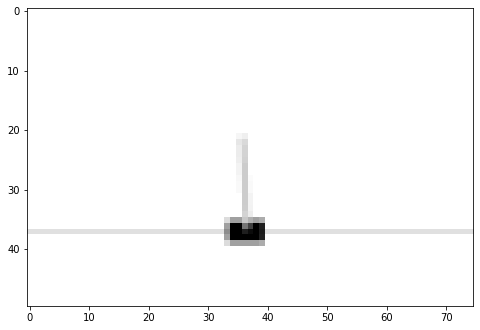

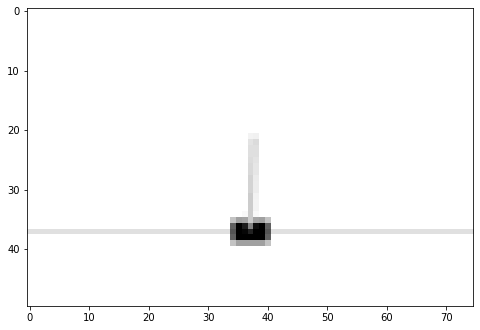

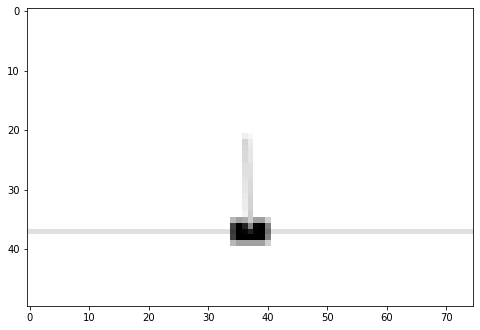

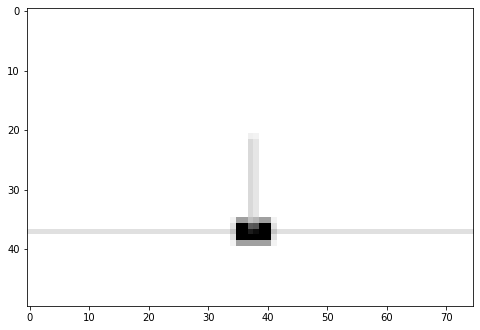

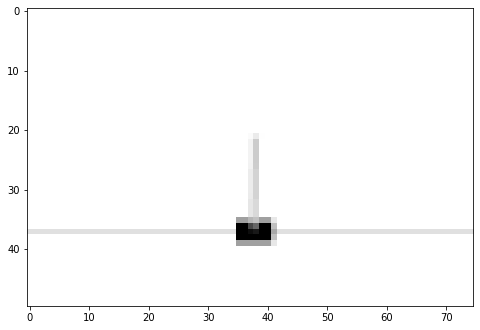

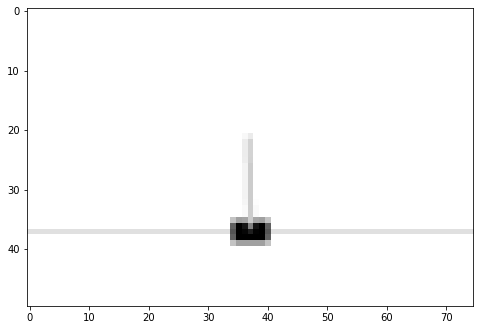

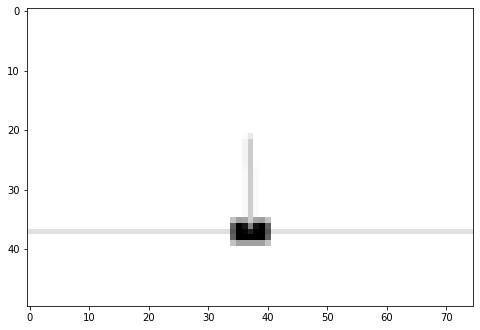

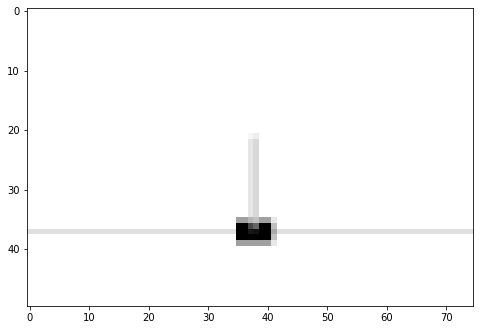

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    image = get_frame(env)
    print(image.shape)
    fig = plt.figure(figsize=(8,8))
    plt.imshow(image[0][0], cmap='gray')
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

In [ ]:
class DQN(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()

        self.convolution = nn.Sequential(
                  nn.Conv2d(channels, 16, kernel_size=(3, 3), stride=2, padding=1),
                  nn.ReLU(),
                  nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1),
                  nn.ReLU(),
                  nn.Conv2d(32, 64, kernel_size=(3, 3), stride=2, padding=1),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2, padding=1),
                )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1280, 640),
            nn.Tanh(),
            nn.Linear(640, 320),
            nn.Tanh(),
            nn.Linear(320, action_space_dim)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = self.flatten(x)
        return self.linear(x)

In [ ]:
# Define an example network
env = gym.make('CartPole-v1') 
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True)
state = env.reset()
image = get_frame(env)
print(image.shape)
net = DQN(channels=image.shape[1], action_space_dim=2)

out = net(image)
print("OUTPUT")
print(out.shape)

torch.Size([1, 1, 50, 75])
OUTPUT
torch.Size([1, 2])


In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out[0] / temperature, dim=0).numpy()
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions, p=softmax_out)
    
    return action, net_out.numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

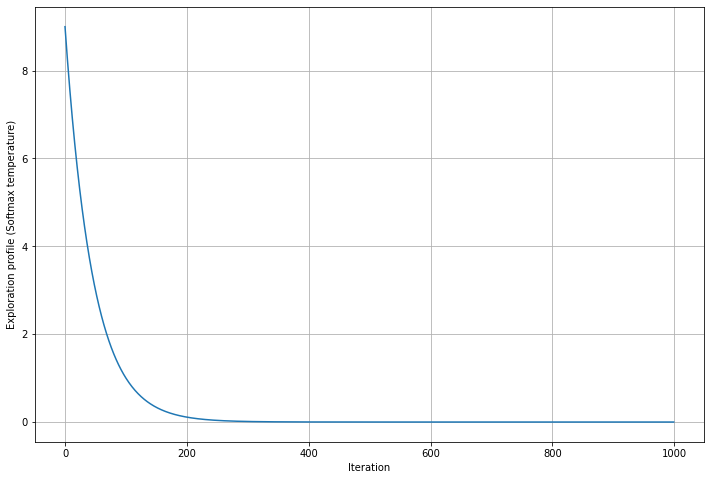

In [ ]:
### Define exploration profile
initial_value = 9
mul_iter = 10
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * mul_iter) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
env.reset()
frame = get_frame(env)
# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = frame.shape[1]
action_space_dim = env.action_space.n

print(f"CHANNELS: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

CHANNELS: 1
ACTION SPACE SIZE: 2


In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 100000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    #states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    states      = torch.stack([s[0][0] for s in batch])
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    #non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_next_states = torch.stack([s[2][0] for s in batch if s[2] is not None])
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

scores = []

skip_frames = 5

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    image = env.render(mode='rgb_array')
    frame = get_frame(env)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    count_frame = 1
    frames_to_stack = []
    next_frame = None
    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, frame, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      pos_weight = -1
      reward = reward + pos_weight * np.abs(state[0])

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      if not done and count_frame % skip_frames == 0:
        next_frame = stack_frames(frames_to_stack)#get_frame(env)
        
      else:
        f = get_frame(env)
        frames_to_stack.append(f)

      # Update the replay memory
      if next_frame != None:
        replay_mem.push(frame, action, next_frame, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      if next_frame != None:
        state = next_state
        frame = next_frame
      count_frame += 1

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    scores.append(score)

env.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 9.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 8.80440647156254
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 8.613063701832482
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 8.42587931071048
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 8.242762925758251
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 8.06362613856686
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 7.8883824620732135
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 7.716947288804205
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 7.549237850028304
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 7.385173175794898
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 7.224674055842075
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 7.067663001353995
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 6.91406420754936
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 6.7638035170829465
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 6.616808384242507
EPISODE: 16 - FINAL SCORE:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 101 - FINAL SCORE: 11 - Temperature: 0.9999999999999988
EPISODE: 102 - FINAL SCORE: 15 - Temperature: 0.9782673857291699
EPISODE: 103 - FINAL SCORE: 14 - Temperature: 0.9570070779813857
EPISODE: 104 - FINAL SCORE: 12 - Temperature: 0.9362088123011633
EPISODE: 105 - FINAL SCORE: 19 - Temperature: 0.9158625473064713
EPISODE: 106 - FINAL SCORE: 24 - Temperature: 0.8959584598407611
EPISODE: 107 - FINAL SCORE: 29 - Temperature: 0.8764869402303559
EPISODE: 108 - FINAL SCORE: 12 - Temperature: 0.8574385876449105
EPISODE: 109 - FINAL SCORE: 13 - Temperature: 0.8388042055586995
EPISODE: 110 - FINAL SCORE: 42 - Temperature: 0.8205747973105432
Updating target network...
EPISODE: 111 - FINAL SCORE: 14 - Temperature: 0.8027415617602296
EPISODE: 112 - FINAL SCORE: 11 - Temperature: 0.7852958890393318
EPISODE: 113 - FINAL SCORE: 38 - Temperature: 0.7682293563943724
EPISODE: 114 - FINAL SCORE: 29 - Temperature: 0.7515337241203264
EPISODE: 115 - FINAL SCORE: 21 - Tem

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 201 - FINAL SCORE: 43 - Temperature: 0.11111111111111084
EPISODE: 202 - FINAL SCORE: 19 - Temperature: 0.10869637619212986
EPISODE: 203 - FINAL SCORE: 12 - Temperature: 0.10633411977570939
EPISODE: 204 - FINAL SCORE: 13 - Temperature: 0.1040232013667958
EPISODE: 205 - FINAL SCORE: 28 - Temperature: 0.10176250525627446
EPISODE: 206 - FINAL SCORE: 73 - Temperature: 0.09955093998230666
EPISODE: 207 - FINAL SCORE: 13 - Temperature: 0.09738743780337276
EPISODE: 208 - FINAL SCORE: 31 - Temperature: 0.09527095418276772
EPISODE: 209 - FINAL SCORE: 10 - Temperature: 0.09320046728429983
EPISODE: 210 - FINAL SCORE: 20 - Temperature: 0.09117497747894913
Updating target network...
EPISODE: 211 - FINAL SCORE: 20 - Temperature: 0.08919350686224763
EPISODE: 212 - FINAL SCORE: 30 - Temperature: 0.08725509878214788
EPISODE: 213 - FINAL SCORE: 28 - Temperature: 0.08535881737715238
EPISODE: 214 - FINAL SCORE: 37 - Temperature: 0.08350374712448061
EPISODE: 215 - FINAL SC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 301 - FINAL SCORE: 17 - Temperature: 0.012345679012345633
EPISODE: 302 - FINAL SCORE: 12 - Temperature: 0.01207737513245886
EPISODE: 303 - FINAL SCORE: 15 - Temperature: 0.01181490219730103
EPISODE: 304 - FINAL SCORE: 26 - Temperature: 0.011558133485199518
EPISODE: 305 - FINAL SCORE: 11 - Temperature: 0.011306945028474928
EPISODE: 306 - FINAL SCORE: 34 - Temperature: 0.011061215553589614
EPISODE: 307 - FINAL SCORE: 24 - Temperature: 0.01082082642259696
EPISODE: 308 - FINAL SCORE: 17 - Temperature: 0.010585661575863067
EPISODE: 309 - FINAL SCORE: 16 - Temperature: 0.010355607476033302
EPISODE: 310 - FINAL SCORE: 19 - Temperature: 0.010130553053216558
Updating target network...
EPISODE: 311 - FINAL SCORE: 20 - Temperature: 0.009910389651360835
EPISODE: 312 - FINAL SCORE: 19 - Temperature: 0.009695010975794196
EPISODE: 313 - FINAL SCORE: 20 - Temperature: 0.00948431304190581
EPISODE: 314 - FINAL SCORE: 16 - Temperature: 0.009278194124942279
EPISODE: 315

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 401 - FINAL SCORE: 21 - Temperature: 0.0013717421124828464
EPISODE: 402 - FINAL SCORE: 13 - Temperature: 0.0013419305702732048
EPISODE: 403 - FINAL SCORE: 55 - Temperature: 0.001312766910811224
EPISODE: 404 - FINAL SCORE: 19 - Temperature: 0.001284237053911056
EPISODE: 405 - FINAL SCORE: 38 - Temperature: 0.0012563272253861015
EPISODE: 406 - FINAL SCORE: 12 - Temperature: 0.0012290239503988446
EPISODE: 407 - FINAL SCORE: 23 - Temperature: 0.0012023140469552163
EPISODE: 408 - FINAL SCORE: 16 - Temperature: 0.0011761846195403394
EPISODE: 409 - FINAL SCORE: 32 - Temperature: 0.0011506230528925876
EPISODE: 410 - FINAL SCORE: 54 - Temperature: 0.0011256170059129494
Updating target network...
EPISODE: 411 - FINAL SCORE: 36 - Temperature: 0.0011011544057067581
EPISODE: 412 - FINAL SCORE: 13 - Temperature: 0.0010772234417549093
EPISODE: 413 - FINAL SCORE: 25 - Temperature: 0.0010538125602117553
EPISODE: 414 - FINAL SCORE: 25 - Temperature: 0.0010309104583269

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 501 - FINAL SCORE: 13 - Temperature: 0.00015241579027587166
EPISODE: 502 - FINAL SCORE: 92 - Temperature: 0.00014910339669702257
EPISODE: 503 - FINAL SCORE: 28 - Temperature: 0.0001458629900901358
EPISODE: 504 - FINAL SCORE: 14 - Temperature: 0.00014269300599011715
EPISODE: 505 - FINAL SCORE: 20 - Temperature: 0.0001395919139317889
EPISODE: 506 - FINAL SCORE: 28 - Temperature: 0.00013655821671098258
EPISODE: 507 - FINAL SCORE: 31 - Temperature: 0.00013359044966169053
EPISODE: 508 - FINAL SCORE: 25 - Temperature: 0.00013068717994892644
EPISODE: 509 - FINAL SCORE: 98 - Temperature: 0.00012784700587695403
EPISODE: 510 - FINAL SCORE: 38 - Temperature: 0.0001250685562125498
Updating target network...
EPISODE: 511 - FINAL SCORE: 26 - Temperature: 0.00012235048952297299
EPISODE: 512 - FINAL SCORE: 25 - Temperature: 0.00011969149352832312
EPISODE: 513 - FINAL SCORE: 12 - Temperature: 0.00011709028446797267
EPISODE: 514 - FINAL SCORE: 30 - Temperature: 0.0001

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 601 - FINAL SCORE: 27 - Temperature: 1.6935087808430164e-05
EPISODE: 602 - FINAL SCORE: 18 - Temperature: 1.6567044077446932e-05
EPISODE: 603 - FINAL SCORE: 21 - Temperature: 1.620699889890396e-05
EPISODE: 604 - FINAL SCORE: 15 - Temperature: 1.585477844334633e-05
EPISODE: 605 - FINAL SCORE: 21 - Temperature: 1.5510212659087634e-05
EPISODE: 606 - FINAL SCORE: 14 - Temperature: 1.5173135190109157e-05
EPISODE: 607 - FINAL SCORE: 23 - Temperature: 1.4843383295743376e-05
EPISODE: 608 - FINAL SCORE: 22 - Temperature: 1.4520797772102919e-05
EPISODE: 609 - FINAL SCORE: 26 - Temperature: 1.4205222875217095e-05
EPISODE: 610 - FINAL SCORE: 23 - Temperature: 1.389650624583885e-05
Updating target network...
EPISODE: 611 - FINAL SCORE: 22 - Temperature: 1.3594498835885868e-05
EPISODE: 612 - FINAL SCORE: 16 - Temperature: 1.329905483648033e-05
EPISODE: 613 - FINAL SCORE: 21 - Temperature: 1.3010031607552502e-05
EPISODE: 614 - FINAL SCORE: 10 - Temperature: 1.27272

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 701 - FINAL SCORE: 37 - Temperature: 1.8816764231589047e-06
EPISODE: 702 - FINAL SCORE: 43 - Temperature: 1.8407826752718793e-06
EPISODE: 703 - FINAL SCORE: 45 - Temperature: 1.800777655433771e-06
EPISODE: 704 - FINAL SCORE: 29 - Temperature: 1.7616420492607012e-06
EPISODE: 705 - FINAL SCORE: 32 - Temperature: 1.723356962120846e-06
EPISODE: 706 - FINAL SCORE: 15 - Temperature: 1.6859039100121266e-06
EPISODE: 707 - FINAL SCORE: 34 - Temperature: 1.6492648106381507e-06
EPISODE: 708 - FINAL SCORE: 10 - Temperature: 1.6134219746781002e-06
EPISODE: 709 - FINAL SCORE: 13 - Temperature: 1.578358097246342e-06
EPISODE: 710 - FINAL SCORE: 39 - Temperature: 1.544056249537648e-06
Updating target network...
EPISODE: 711 - FINAL SCORE: 23 - Temperature: 1.5104998706539837e-06
EPISODE: 712 - FINAL SCORE: 20 - Temperature: 1.4776727596089238e-06
EPISODE: 713 - FINAL SCORE: 30 - Temperature: 1.4455590675058318e-06
EPISODE: 714 - FINAL SCORE: 18 - Temperature: 1.41414

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 801 - FINAL SCORE: 17 - Temperature: 2.0907515812876693e-07
EPISODE: 802 - FINAL SCORE: 27 - Temperature: 2.045314083635419e-07
EPISODE: 803 - FINAL SCORE: 22 - Temperature: 2.0008640615930765e-07
EPISODE: 804 - FINAL SCORE: 35 - Temperature: 1.9573800547341102e-07
EPISODE: 805 - FINAL SCORE: 65 - Temperature: 1.9148410690231602e-07
EPISODE: 806 - FINAL SCORE: 14 - Temperature: 1.8732265666801382e-07
EPISODE: 807 - FINAL SCORE: 15 - Temperature: 1.8325164562646098e-07
EPISODE: 808 - FINAL SCORE: 11 - Temperature: 1.7926910829756647e-07
EPISODE: 809 - FINAL SCORE: 11 - Temperature: 1.7537312191626e-07
EPISODE: 810 - FINAL SCORE: 22 - Temperature: 1.7156180550418288e-07
Updating target network...
EPISODE: 811 - FINAL SCORE: 18 - Temperature: 1.6783331896155356e-07
EPISODE: 812 - FINAL SCORE: 24 - Temperature: 1.641858621787691e-07
EPISODE: 813 - FINAL SCORE: 55 - Temperature: 1.6061767416731444e-07
EPISODE: 814 - FINAL SCORE: 19 - Temperature: 1.571270

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 901 - FINAL SCORE: 41 - Temperature: 2.3230573125418522e-08
EPISODE: 902 - FINAL SCORE: 21 - Temperature: 2.2725712040393514e-08
EPISODE: 903 - FINAL SCORE: 22 - Temperature: 2.2231822906589713e-08
EPISODE: 904 - FINAL SCORE: 16 - Temperature: 2.174866727482342e-08
EPISODE: 905 - FINAL SCORE: 27 - Temperature: 2.1276011878035086e-08
EPISODE: 906 - FINAL SCORE: 25 - Temperature: 2.0813628518668175e-08
EPISODE: 907 - FINAL SCORE: 15 - Temperature: 2.0361293958495638e-08
EPISODE: 908 - FINAL SCORE: 14 - Temperature: 1.9918789810840692e-08
EPISODE: 909 - FINAL SCORE: 18 - Temperature: 1.9485902435139978e-08
EPISODE: 910 - FINAL SCORE: 23 - Temperature: 1.9062422833798075e-08
Updating target network...
EPISODE: 911 - FINAL SCORE: 21 - Temperature: 1.86481465512837e-08
EPISODE: 912 - FINAL SCORE: 21 - Temperature: 1.8242873575418766e-08
EPISODE: 913 - FINAL SCORE: 23 - Temperature: 1.7846408240812695e-08
EPISODE: 914 - FINAL SCORE: 19 - Temperature: 1.7458

No handles with labels found to put in legend.


Text(0, 0.5, 'Scores')

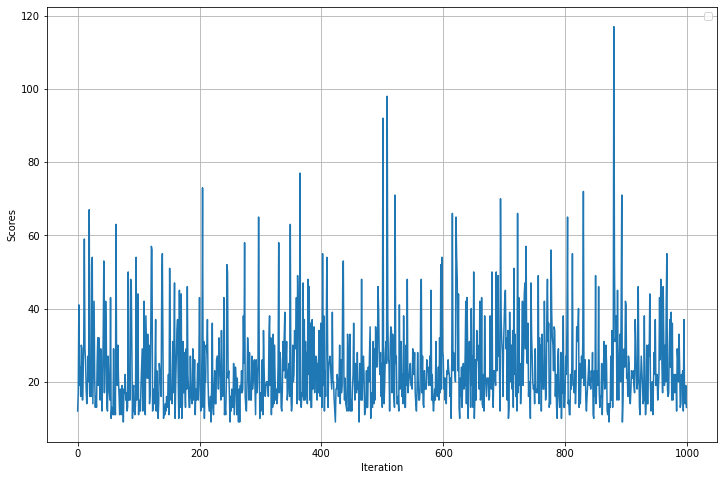

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(scores)
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')